# EI balance in different CA1 neurons.

In [1]:
import sys
sys.path.append("../")
import glob
from Linearity import Neuron
import numpy as np
import scipy.stats as ss
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.font_manager import findfont, FontProperties
plt.style.use('neuron')
from pickle import dump

In [2]:
def simpleaxis(axes, every=False, outward=True):
    if not isinstance(axes, (list, np.ndarray)):
        axes = [axes]
    for ax in axes:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        if (outward):
            ax.spines['bottom'].set_position(('outward', 10))
            ax.spines['left'].set_position(('outward', 10))
        if every:
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_title('')

In [3]:
#Colorscheme for squares
color_sqr = { index+1: color for index, color in enumerate(matplotlib.cm.viridis(np.linspace(0,1,9)))}

In [4]:
voltageClampFiles = '/media/sahil/NCBS_Shares_BGStim/patch_data/voltage_clamp_files.txt'

In [5]:
with open (voltageClampFiles,'r') as r:
    dirnames = r.read().splitlines()

In [6]:
#Colorscheme for cells
color_cell = matplotlib.cm.plasma(np.linspace(0,1,len(dirnames)))

In [7]:
neurons = []
for dirname in dirnames:
    cellIndex = dirname.split('/')[-2]
    filename = dirname + 'plots/' + cellIndex + '.pkl'
    neurons.append(Neuron.load(filename))

In [52]:
feature = 0
scalingFactor = 1e9
r_squared = []
slopes = []
for index, n in enumerate(neurons):
#     if index != (len(neurons) - 1) and index != (len(neurons) - 3) :
        obs_exc, obs_inh = {}, {}
        sqrs = []
#         f, ax = plt.subplots()
        for expType,expt in n:
            for sqr in expt:
                if (expType == 1):
                    sqrs.append(sqr)
                    for coord in expt[sqr].coordwise:
                        obs_exc[coord] = expt[sqr].coordwise[coord].average_feature[5]
                elif (expType == 2):
                    for coord in expt[sqr].coordwise:
                        obs_inh[coord] = expt[sqr].coordwise[coord].average_feature[0]

        exc, inh = [], []
        for coord in set(obs_exc).intersection(set(obs_inh)):
            exc.append(-obs_exc[coord]*scalingFactor)
            inh.append(obs_inh[coord]*scalingFactor)
#             ax.scatter(-obs_exc[coord]*scalingFactor, obs_inh[coord]*scalingFactor, c=color_cell[index], s=10)
        
        slope, intercept, rval, pval, stderr = ss.linregress(exc, inh)
        r_squared.append(rval**2)
        slopes.append(slope)

#         excRange = np.linspace(0, max(exc), 100)
#         inhFit = excRange*slope + intercept

#         ax.plot(excRange, inhFit, c=color_cell[index])
#         xlim_old = ax.get_xlim()
#         ylim_old = ax.get_ylim()
#         minlim, maxlim = min(xlim_old[0], ylim_old[0]), max(xlim_old[1], ylim_old[1])
#         ax.set_xlim(0,maxlim)
#         ax.set_ylim(0,maxlim)
#         print (index,n.date, n.index)
#         plt.show()

# ax.set_title("Linear regression showing proportional E and I")
# ax.set_xlabel("")
# ax.set_ylabel("")
# plt.legend(scatterPoints=sqrs, label=sqrs)


## Figure 2 C (Example Cell)

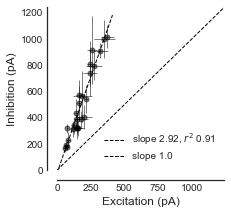

In [53]:
index = -4
n = neurons[index]
obs_exc, obs_inh = {}, {}
exc_error, inh_error = {}, {}
sqrs = []
fig, ax = plt.subplots()
# fig.suptitle("Representative cell {}, {}".format(n.index,n.date), fontsize=18)
for expType,expt in n:
    for sqr in expt:
        if (expType == 1):
            sqrs.append(sqr)
            for coord in expt[sqr].coordwise:
                obs_exc[coord] = expt[sqr].coordwise[coord].average_feature[5]
                exc_error[coord] = np.std([trial.feature[5] for trial in expt[sqr].coordwise[coord].trials], ddof = 1)
        elif (expType == 2):
            for coord in expt[sqr].coordwise:
                obs_inh[coord] = expt[sqr].coordwise[coord].average_feature[0]
                inh_error[coord] = np.std([trial.feature[0] for trial in expt[sqr].coordwise[coord].trials], ddof = 1)

exc, inh = [], []
for coord in set(obs_exc).intersection(set(obs_inh)):
    exc.append(-obs_exc[coord]*scalingFactor)
    inh.append(obs_inh[coord]*scalingFactor)
    ax.errorbar(-obs_exc[coord]*scalingFactor, obs_inh[coord]*scalingFactor, xerr=exc_error[coord]*scalingFactor, yerr=inh_error[coord]*scalingFactor, c='k', fmt='.', alpha=0.5)

slope, intercept, rval, pval, stderr = ss.linregress(exc, inh)

excRange = np.linspace(0, 1.1*max(exc), 100)
inhFit = excRange*slope + intercept

ax.plot(excRange, inhFit, '--', c='k', label="slope {:.2f}, $r^2$ {:.2f}".format(slope, rval**2))

xlim_old = ax.get_xlim()
ylim_old = ax.get_ylim()
minlim, maxlim = min(xlim_old[0], ylim_old[0]), max(xlim_old[1], ylim_old[1])
ax.plot((0,maxlim), (0,maxlim),'--', label="slope 1.0")
ax.set_xlim(0,maxlim)
ax.set_ylim(0,maxlim)
ax.set_xlabel("Excitation (pA)")
ax.set_ylabel("Inhibition (pA)")
fig.set_figheight(3)
fig.set_figwidth(3)
simpleaxis(ax)
dump(fig,file('figures/fig2/2c.pkl','wb'))
plt.legend(loc='lower right')
plt.show()

## Figures 2 D, E (Statistics)

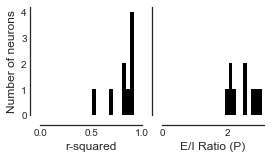

In [57]:
fig, ax = plt.subplots(1,2, sharey=True)

ax[0].hist(r_squared)
# ax[0].set_title("$r^2$ for linear regression")
ax[0].set_xlabel("r-squared")
ax[0].set_ylabel("# neurons")
ax[0].set_xlim((0,1))

ax[1].hist(slopes)
# ax[1].set_title("Different proportionality $P$ for E and I")
ax[1].set_xlabel("E/I Ratio (P)")
# ax[1].set_ylabel("Number of neurons")
ax[1].yaxis.set_visible(False)
ax[1].set_xlim(xmin=0)
fig.set_figheight(2)
fig.set_figwidth(4)
simpleaxis(ax)
dump(fig,file('figures/fig2/2d.pkl','wb'))
plt.show()

In [45]:
np.mean(r_squared), np.std(r_squared)

(0.81958404798508211, 0.13179758506026718)

## Figure 2 F: r-square and I/E changes with number of squares

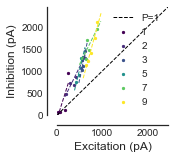

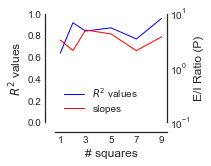

In [60]:
r_squared = []
slopes = []
index = -1
n = neurons[index]
obs_exc, obs_inh = {}, {}
sqrs = {}

fig, ax = plt.subplots()
# f.suptitle("Representative cell {}, {}".format(n.index,n.date), fontsize=18)

r_sqrs, slopes, sqrs = [], [], []

for sqr in set(n.experiment[1]).intersection(set(n.experiment[2])):
    exc, inh = [], []
    exc_error, inh_error = [], []
    for coord in set(n.experiment[1][sqr].coordwise).intersection(set(n.experiment[1][sqr].coordwise)):
        exc.append(-n.experiment[1][sqr].coordwise[coord].average_feature[5]*scalingFactor)
        inh.append(n.experiment[2][sqr].coordwise[coord].average_feature[0]*scalingFactor)
        exc_error.append(np.std([trial.feature[5] for trial in n.experiment[1][sqr].coordwise[coord].trials], ddof = 1)*scalingFactor)
        inh_error.append(np.std([trial.feature[0] for trial in n.experiment[2][sqr].coordwise[coord].trials], ddof = 1)*scalingFactor)
    ax.scatter(exc, inh, c=color_sqr[sqr], s=5, label=sqr)
    #ax[0].errorbar(exc, inh, xerr=exc_error, yerr=inh_error, c='k', fmt='.', alpha=0.1)

    slope, intercept, rval, pval, stderr = ss.linregress(exc, inh)

    excRange = np.linspace(0.9*min(exc), 1.1*max(exc), 100)
    inhFit = excRange*slope + intercept

    ax.plot(excRange, inhFit, '--', c=color_sqr[sqr])
    sqrs.append(sqr)
    slopes.append(slope)
    r_sqrs.append(rval**2)

xlim_old = ax.get_xlim()
ylim_old = ax.get_ylim()
minlim, maxlim = min(xlim_old[0], ylim_old[0]), max(xlim_old[1], ylim_old[1])
ax.plot((0,maxlim), (0,maxlim),'--', label="P=1")
ax.set_xlim(0,maxlim)
ax.set_ylim(0,maxlim)
ax.set_title("Linear regression showing proportional E and I")
ax.set_xlabel("Excitation (pA)")
ax.set_ylabel("Inhibition (pA)")
ax.legend(loc='lower right')
fig.set_figheight(2)
fig.set_figwidth(2)
simpleaxis(ax)
dump(fig,file('figures/fig2/2f1.pkl','wb'))
plt.show()

fig, ax = plt.subplots()
line1 = ax.plot(sqrs, r_sqrs, label="$R^2$ values",c='b')
ax.set_ylim((0,1))
ax.xaxis.set_ticks([1,3,5,7,9])
ax_copy = ax.twinx()
line2 = ax_copy.plot(sqrs, slopes, label="slopes",c='r')
ax.set_title("Different number of squares show consistent EI ratios")
ax.set_xlabel("# squares")
ax.set_ylabel("$R^2$ values")
ax_copy.set_ylim((0.1,10))
ax_copy.set_ylabel("E/I Ratio (P)")
ax_copy.set_yscale("log")

lines = line1+line2
labs = [l.get_label() for l in lines]
ax.legend(lines, labs, loc=0)
fig.set_figheight(2)
fig.set_figwidth(2)
simpleaxis(ax)
simpleaxis(ax_copy,every=True)
ax_copy.spines['right'].set_visible(True)
ax_copy.get_yaxis().tick_right()

dump(fig,file('figures/fig2/2f2.pkl','wb'))
plt.show()

    A. shows tight balance between tight balance between excitation and inhibition at the CA1 neuron. 
    B. shows r-square for linear regression showing high degree of correlation between E and I. 
    C. showing different proportionality P of all CA1 neurons.